In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from joblib import load

In [3]:
class FootballPreprocessor(BaseEstimator, TransformerMixin):
    '''
    preprocessor class, dropsmissing, dummies, polynomials, assigns class to target,
    takes target out of dataset, gets coeficient names and makes the train test split
    
        target: str of target column
        to_drop: list of columns to drop
        to_dummy: list of columns to dummy
        test_size: testset as fraction as total dataset
        dropna: bool, True drops rows with np.nan values, default is True
        classify: bool, True uses the assign class function and stratifys the train test split
                  designed for processing data for classifiers
        threshold: int, if y>int return 1. used to create the classes in the target.
        poly: bool, True returns dataset with 2-degree polynomials of original dataset
              the coef_names are adjusted to fit the new number of features.
    '''
    def __init__(self, target, to_drop=None, to_dummy=None, test_size=0.3, dropna=True, classify=False, threshold=None, poly=False, time_split=False,when=77):
        self.to_drop=to_drop
        self.to_dummy=to_dummy
        self.test_size=test_size
        self.target=target
        self.dropna=dropna
        self.classify=classify
        self.threshold=threshold
        self.poly=poly
        self.time_split=time_split
        self.when=when
        
    def fill_missing_teams(self, X):
        '''
        fills missing values with 0
        for teams that cross from train to 
        test set but might not be in all seasons
        '''
        teams=['ARS', 'BOU', 'BHA', 'BUR', 'CHE', 'CRY', 'EVE','NEW',
        'HUD', 'LEI', 'LIV', 'MCI', 'MUN', 'SOU', 'TOT', 'WAT',
       'WHU']
        for team in teams:
            try:
                X[team]=X[team].fillna(value=0)
            except:
                continue
        return X
        
    def dropmissing(self, X):
        '''
        drops missing values, for the designed data set this will
        take out rows without lags. removing the first 2 weeks for
        each player
        '''
        X.dropna(inplace=True)
        return X
        
    def get_target(self, X):
        '''
        pops out target creating a y series
        '''
        y=X.pop(target)
        return X,y
        
    def drop_me(self, X):
        '''
        drops any columns specified
        '''
        droping=self.to_drop
        X=X.drop(droping, axis=1)
        return X
    
    def dummy_me(self, X):
        '''
        dummies any columns specified if position
        or team so doesnt drop first as unkowns 
        and dropout teams will be force
        dropped later
        '''
        if ('position' in self.to_dummy) or ('team' in self.to_dummy):
            dummying = [col for col in self.to_dummy if (col!='position') and (col!='team')]
            X=pd.get_dummies(X,columns=dummying,drop_first=True)
            
            if 'position' in self.to_dummy:
                X=pd.get_dummies(X,columns=['position'])
                
            if 'team' in self.to_dummy:
                X=pd.get_dummies(X,columns=['team'])
        else:
            dummying=self.to_dummy
            X=pd.get_dummies(X,columns=dummying)
        return X
    
    def polyfi(self, X):
        '''
        creates the polynomial of the X features, also gets the coef names
        returns both. no keyword for more than 2 degrees
        '''
        poly=PolynomialFeatures()#2degrees
        coef_names=poly.fit(X).get_feature_names(X.columns)
        coef_names=[col.replace(' ', '_x_') for col in coef_names]
        X=poly.fit_transform(X)
        X=pd.DataFrame(X,columns=coef_names)
        return X
    
    def assign_class(self, row):
        '''
        The .apply function used to classifiy the target
        '''
        if row > self.threshold:
            return 1
        else:
            return 0
        
    def create_class(self, y):
        '''
        function that employs the .apply function to classify y
        '''
        y = y.apply(self.assign_class)
        return y
    
    def get_coef_names(self, X):
        '''
        gets coef names for X features
        '''
        return X.columns
    
    def train_test(self, X, y):
        '''
        makes train test split, if classify == True then uses stratify.
        '''
        if self.classify==True:
            return train_test_split(X,y,test_size=self.test_size,stratify=y,random_state=1)
        else:
            return train_test_split(X,y,test_size=self.test_size)
    
    def make_time_split(self, X, y):
        '''
        default=adj_round 77
        makes the test set the 2018/19 season
        the train set is the 2016/17 and 2017/18 season
        '''
        
        print('X', X.shape)
        
        X_test = X[X['adj_round']>=self.when]
        
        X_train = X[X['adj_round']<self.when]
        
        train_loc = list(X_train.index)
        test_loc = list(X_test.index)
        y_train = y.loc[train_loc]
        y_test = y.loc[test_loc]
        
        X_train=X_train.drop('adj_round', axis=1)
        X_test=X_test.drop('adj_round', axis=1)
        
        print('X_train',X_train.shape)
        print('X_test',X_test.shape)
        return X_train, X_test, y_train, y_test
    
    def drop_unkowns(self, X):
        X = X.drop('position_unkown',axis=1)
        return X
    
    def clear_dummies(self, X):
        drop_dummies=['STO', 'FUL', 'SWA', 'MID', 
        'SUN', 'WOL', 'WBA', 'CAR', 'HUL','unkown']
        to_stay=X.columns
        
        for dum in drop_dummies:
            to_stay=[col for col in to_stay if dum not in col]
        
        to_drop=[col for col in X.columns if col not in to_stay]
        X=X.drop(to_drop,axis=1)
        return X
            
            
    
    def transform(self, X):
        '''
        channels different inputs to the right functions. 
        returns train test split data and the coef_names
        '''
        
        
        
        if self.to_drop != None:
            X=self.drop_me(X)
            
            
        if self.to_dummy != None:
            X=self.dummy_me(X)
            X=self.clear_dummies(X)
            
        X=self.fill_missing_teams(X)
        
        
        if self.dropna==True:
            X=self.dropmissing(X)
            
        
        
       # if 'position' in self.to_dummy:
          #  X = self.drop_unkowns(X)
            
        X,y=self.get_target(X)
        
        if self.poly==True:
            X = self.polyfi(X)
            
        if self.classify == True:
            y=self.create_class(y)
        
        
            
        if self.time_split==False:
            X_train, X_test, y_train, y_test = self.train_test(X,y)
        else:
            X_train, X_test, y_train, y_test = self.make_time_split(X,y)
        
        coef_names=self.get_coef_names(X_train)
            
        return X_train, X_test, y_train, y_test, coef_names
    
    def fit(self, X):
        return self



In [72]:
sns.set(style='white',
        rc={'axes.facecolor':'#FFFFFF', 
            'figure.facecolor':'#FFFFFF'})

facecolour = '#FFFFFF'
axiscolour = '#000000'
secondarycolour = '#008000'
tertiarycolour = '#ff0000'

def color_axis(ax, facecolour=facecolour, axiscolour=axiscolour):
    ax.spines['bottom'].set_color(axiscolour)
    ax.spines['top'].set_color(facecolour)
    ax.spines['left'].set_color(axiscolour)
    ax.spines['right'].set_color(facecolour)
    ax.tick_params(axis='x',colors=axiscolour)
    ax.tick_params(axis='y',colors=axiscolour)
    ax.xaxis.label.set_color(axiscolour)
    ax.yaxis.label.set_color(axiscolour)
    return ax

In [106]:
#regression analysis functions

def resid(y, pred, filename, facecolour=facecolour, axiscolour=axiscolour):
    res = y-pred
    res = pd.Series(res, name='residuals')

    fig, ax = plt.subplots(figsize=(12,6))
    sns.distplot(res,kde=False,color=axiscolour,ax=ax,
                hist_kws={'alpha':1,'linewidth':0},bins=100)
    ax=color_axis(ax)
    plt.savefig(f'{filename}.png', facecolor=facecolour)

def link_to_data(data, index, pred):
    '''
    links the data rows with the predicted
    classes by putting both in dataframes and 
    joining, indexes from the observed y series are
    used.
    '''
    pred = pd.Series(pred, index=index, name='pred_y')
    df = data.loc[index]
    df = pd.concat([df, pred], axis=1)
    return df

def within_r(row, r):
    '''
    assigns binary to column dependent on 
    if the prediction is within r of the 
    observation.
    '''
    obs=row['next_week_points']
    pred=row['pred_y']
    try:
        ratio = pred/obs
    except:
        #obs==0
        if (pred<0.3) and (pred>-0.3):
            return 1
        else:
            return 0
    upper=1+r
    lower=1-r
    if (ratio<=upper) and (ratio>=lower):
        return 1
    else:
        return 0
    
    
def apply_quants(row, tiles):
    '''
    assigns binary to column dependent on
    which half of the totalpoints dist that 
    week the row is in.
    '''
    gw = row['round']
    y = row['next_week_points']
    try:
        tile=tiles[gw-4]#first game is 3
    except:
        print(gw, row.name)
    if y<=tile:
        return 0
    else:
        return 1
    
def pred_ovr_time(data_file, train_data, index, model, file_name1, file_name2, facecolour=facecolour, axiscolour=axiscolour, secondarycolour=secondarycolour, tertiarycolour=tertiarycolour):
    '''
    prints line graph of predictions vs observations
    over time. Seperates data into high point and low
    point players.
    '''
    data=pd.read_csv(data_file)
    
    data_reg=data.loc[index]
    
    df = link_to_data(data_reg, index, model.predict(train_data))
    
    
    gw_index = [(i,x) for i,x in enumerate(df['round'].unique())]
    avg_obs=[]
    avg_preds=[]
    tiles=[]
    for gw in df['round'].unique():
        avg_ob=df[df['round']==gw]['next_week_points'].mean()
        avg_pred=df[df['round']==gw]['pred_y'].mean()

        avg_obs.append(avg_ob)
        avg_preds.append(avg_pred)

        half_tile=df[df['round']==gw]['next_week_points'].quantile(0.5)

        tiles.append(half_tile)
    


    df['tile']=df.apply(apply_quants, tiles=tiles, axis=1)

    lower_obs=[]
    upper_obs=[]
    lower_pred=[]
    upper_pred=[]
    for gw in df['round'].unique():
        tmp=df[df['round']==gw]
        lower_mean_obs=tmp[tmp['tile']==0]['next_week_points'].mean()
        upper_mean_obs=tmp[tmp['tile']==1]['next_week_points'].mean()

        lower_mean_pred=tmp[tmp['tile']==0]['pred_y'].mean()
        upper_mean_pred=tmp[tmp['tile']==1]['pred_y'].mean()

        lower_obs.append(lower_mean_obs)
        upper_obs.append(upper_mean_obs)

        lower_pred.append(lower_mean_pred)
        upper_pred.append(upper_mean_pred)

    fig, ax = plt.subplots(figsize=(12,6))


    sns.lineplot(x=df['round'].unique(),y=lower_obs, color=secondarycolour,label='lower half observations', ax=ax)
    sns.lineplot(x=df['round'].unique(),y=lower_pred, color=secondarycolour,label='lower half predictions', ax=ax)

    sns.lineplot(x=df['round'].unique(),y=upper_obs, color=tertiarycolour,label='upper half observations', ax=ax)
    sns.lineplot(x=df['round'].unique(),y=upper_pred, color=tertiarycolour,label='upper half predictions', ax=ax)



    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    ax=color_axis(ax)
    l=plt.legend()
    for text in l.get_texts():
        text.set_color(axiscolour)
    plt.savefig(f'{file_name1}.png', facecolor=facecolour)
    
    df['vis_shift_round']=df['round'].apply(shift_round)


    fig,ax=plt.subplots(figsize=(12,6))
    sns.lineplot(x='vis_shift_round', y='pred_y', color=tertiarycolour, label='predicted points next week',ax=ax,
                data=df,estimator='mean',err_style='bars')
    sns.lineplot(x='round', y='next_week_points', color=secondarycolour, label='observed points next week',ax=ax,
                data=df,estimator='mean',err_style='bars')
    ax=color_axis(ax)
    l=plt.legend()
    for text in l.get_texts():
        text.set_color(axiscolour)
    plt.savefig(f'{file_name2}.png', facecolor=facecolour)
    
def shift_round(r):
    return r+0.2

In [744]:
# classification analysis functions
def get_roc(y, proba, facecolour=facecolour, axiscolour=axiscolour, secondarycolour=secondarycolour):
    fpr, tpr, threshold_roc = roc_curve(y, proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, threshold_prc = precision_recall_curve(y, proba)
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,9))
    sns.lineplot(x=fpr,y=tpr,label=f'Area={roc_auc}', ax=ax[0],
                color=axiscolour)
    
    sns.lineplot(x=[0,1],y=[0,1],color=secondarycolour,dashes=True,ax=ax[0])
    ax[0].lines[1].set_linestyle('--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    l=ax[0].legend(loc='lower right')
    ax[0]=color_axis(ax[0])
    for text in l.get_texts():
        text.set_color(axiscolour)

    sns.lineplot(x=recall, y=precision,ax=ax[1],color=axiscolour)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[0]=color_axis(ax[1])
    plt.savefig('roccing.png', facecolor=facecolour)
    
def feature_importance(coefs, names, filename, facecolour=facecolour, axiscolour=axiscolour):
    '''
    works with coefs or feature importance
    produces bar graph of all features.
    '''
    df_cf=pd.DataFrame(coefs, index=names,columns=['real'])
    df_cf['abs']=df_cf['real'].abs()
    df_cf=df_cf.sort_values(by='abs',ascending=False)
    height = df_cf['real'].values
    label = df_cf.index
    
    fig,ax=plt.subplots(figsize=(10,10))
    sns.barplot(x=height, y=label,color=axiscolour,ax=ax,
               linewidth=0)
    ax=color_axis(ax)
    plt.savefig(f'{filename}.png', facecolor=facecolour, pad_inches=3)
    
def confusion(y, proba, thresh):
    y_pred=[1 if x>=thresh else 0 for x in proba]
    conf=np.array(confusion_matrix(y,y_pred,labels=[0,1]))
    conf_df=pd.DataFrame(conf,index=[f'observed <= 3', f'observed > 3'],
                        columns=[f'predicted <= 3', f'predicted > 3'])
    fig, ax = plt.subplots(figsize=(10,8))
    
    sns.heatmap(conf_df, annot=True,ax=ax, cmap=sns.light_palette("green"),
               cbar=False)
    ax=color_axis(ax)
    plt.savefig('confusio.png', facecolor='#317256')
    
def report(y, proba, thresh):
    
    baseline=y.value_counts().values[0]/y.shape[0]
    
    y_pred=[1 if x>=thresh else 0 for x in proba]

    print(f'Baseline: {baseline}')
    print()
    print(f'threshold: {thresh}')
    print(classification_report(y,y_pred,digits=3))
    
    conf=np.array(confusion_matrix(y,y_pred,labels=[0,1]))
    conf_df=pd.DataFrame(conf,index=[f'observed <= 3', f'observed > 3'],
                        columns=[f'predicted <= 3', f'predicted > 3'])

    print(conf_df)
    
def optimize_thresh(model, X_train, y_train, fp_tol):
    '''
    taks 21 values between 0.1 and 0.9 and finds the
    fp/fp+tp closes to the fp_tol provided this threshold
    is then used later in class analysis.
    '''
    proba=model.predict_proba(X_train)
    proba=[x[1] for x in proba]
    
    candidates={}
    for thresh in np.linspace(0.1,0.9,num=21):
        y_pred=[1 if x>=thresh else 0 for x in proba]
        y_train=list(y_train)
        df = pd.DataFrame([y_train,y_pred],index=['obs','pred']).T
        tp = df[(df['obs']==1)&(df['pred']==1)].shape[0]
        fp = df[(df['obs']==0)&(df['pred']==1)].shape[0]
        try:
            fp_rate = fp/(fp+tp)
            candidates[thresh]=fp_rate
        except:
            continue
    optimizer={}
    for thresh in candidates.keys():
        diff = candidates[thresh]-fp_tol
        optimizer[thresh]=np.absolute(diff)
    return min(optimizer, key=optimizer.get)

def assign_class(prob, thresh):
    if prob>thresh:
        return 1
    else:
        return 0
    
def histclass(df,cl_thresh, pred):
    '''
    histogram of players predicted > 3 vs those predicted <= 3
    '''
    points_z = df[df[pred]==0]['next_week_points']
    points_nz = df[df[pred]==1]['next_week_points']
    
    fig,ax=plt.subplots(figsize=(8,8))
    sns.distplot(points_nz, bins=30, color=axiscolour, kde=False,  label=f'dist of players predicted > {cl_thresh}',
                ax=ax, hist_kws={'alpha':1,'linewidth':0})
    sns.distplot(points_z, bins=30, color=secondarycolour, kde=False, label=f'dist of players predicted <= {cl_thresh}',
                hist_kws={'alpha':0.5,'linewidth':0},ax=ax)

    plt.ylim([0,2000])
    ax=color_axis(ax)
    l=plt.legend()
    for text in l.get_texts():
        text.set_color(axiscolour)
    plt.savefig('hist_class.png', facecolor='#317256')
    
    
def dist_of_week(df, cl_thresh, pred):
    
    df_nz = df[df[pred]==1]
    df_z = df[df[pred]==0]
    fig,ax=plt.subplots(figsize=(8,8))
    
    sns.distplot(df_z['adj_round'], color=secondarycolour,bins=35,kde=False,label=f'dist of players predicted <= {cl_thresh}',
                hist_kws={'alpha':1, 'linewidth':0}, ax=ax)
    sns.distplot(df_nz['adj_round'], color=axiscolour,bins=35, kde=False, label=f'dist of players predicted > {cl_thresh}', 
                 hist_kws={'alpha':0.7, 'linewidth':0},ax=ax)
    
    
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color(axiscolour)
        
    ax=color_axis(ax)
        
    plt.savefig('dist_ovr_week.png', facecolor='#317256')

def pts_of_week(df, cl_thresh):
    df_nz = df[df['pred_y']==1]
    df_z = df[df['pred_y']==0]

    points_z = []
    points_nz = []
    for gw in df['adj_round'].unique():
        avg_points_z = df_z[df_z['adj_round']==gw]['next_week_points'].mean()
        avg_points_nz = df_nz[df_nz['adj_round']==gw]['next_week_points'].mean()
        points_z.append(avg_points_z)
        points_nz.append(avg_points_nz)
    
    fig,ax=plt.subplots(figsize=(8,8))
    sns.lineplot(x=df['adj_round'].unique(), y=points_nz, color='#FFDC00', label=f'dist of players predicted > {cl_thresh}', ax=ax)
    sns.lineplot(x=df['adj_round'].unique(), y=points_z, color='#fe0000', label=f'dist of players predicted <= {cl_thresh}', ax=ax)
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color('#FFDC00')
        
    ax=color_axis(ax)
        
    plt.savefig('pts_of_week.png', facecolor='#317256')

def players_over_seasons(df):
    fig,ax=plt.subplots(figsize=(8,8))
    total_players = []
    for gw in df['adj_round'].unique():
        total = len(df[df['adj_round']==gw]['player'].unique())
        total_players.append(total)
    sns.lineplot(x=df['adj_round'].unique(), y=total_players, color='#FFDC00', ax=ax)
    ax=color_axis(ax)
    plt.savefig('playerstotal.png', facecolor='#317256')

def pts_dist(df, cl_thresh):
    fig,ax=plt.subplots(figsize=(8,8))
    sns.distplot(df[df['pred_y']==1]['next_week_points'],kde=False, color='#FFDC00', label=f'dist of players predicted > {cl_thresh}', ax=ax,
                hist_kws={'alpha':1,'linewidth':0})
    sns.distplot(df[df['pred_y']==0]['next_week_points'],kde=False, color='#fe0000', label=f'dist of players predicted <= {cl_thresh}', ax=ax,
                hist_kws={'alpha':0.5,'linewidth':0})
    
    ax.set_ylim([0,2000])
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color('#FFDC00')
        
    ax=color_axis(ax)
        
    plt.savefig('hist_pts.png', facecolor='#317256')
    

def week_value(df, cl_thresh, pred, axiscolour=axiscolour, facecolour=facecolour, secondarycolour=secondarycolour, tertiarycolour=tertiarycolour):
    '''
    prints histogram of player values
    and values over time
    '''
    df_nz = df[df[f'{pred}']==1]
    df_z = df[df[f'{pred}']==0]
    
    fig,ax=plt.subplots(figsize=(8,8))


    sns.distplot(df_nz['value'], color=axiscolour,bins=35, kde=False, label=f'dist of players predicted > {cl_thresh}',
                hist_kws={'alpha':1,'linewidth':0})
    sns.distplot(df_z['value'], color=secondarycolour,bins=35,kde=False,label=f'dist of players predicted <= {cl_thresh}',
                hist_kws={'alpha':0.5,'linewidth':0})
    
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color(axiscolour)
        
    ax=color_axis(ax)

    plt.show()
    
    fig,ax=plt.subplots(figsize=(12,5))

    sns.distplot(df_nz['value'], color=axiscolour,bins=35, kde=False, label=f'dist of players predicted > {cl_thresh}',
                hist_kws={'alpha':1, 'linewidth':0})
    sns.distplot(df_z['value'], color=secondarycolour,bins=35,kde=False,label=f'dist of players predicted <= {cl_thresh}',
                hist_kws={'alpha':0.5, 'linewidth':0})

    plt.xlim([80,140])
    
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color(axiscolour)
        
    ax=color_axis(ax)
    plt.show()

    values_z = []
    values_nz = []
    values_a=[]
    for gw in df['adj_round'].unique():
        avg_value_z = df_z[df_z['adj_round']==gw]['value'].mean()
        avg_value_a = df[df['adj_round']==gw]['value'].mean()
        avg_value_nz = df_nz[df_nz['adj_round']==gw]['value'].mean()
        values_z.append(avg_value_z)
        values_nz.append(avg_value_nz)
        values_a.append(avg_value_a)
    
    fig,ax=plt.subplots(figsize=(8,8))

    sns.lineplot(x=df['adj_round'].unique(), y=values_nz, color=axiscolour, label=f'average value of player > {cl_thresh}')
    sns.lineplot(x=df['adj_round'].unique(), y=values_z, color='#fe0000', label=f'average value of player <= {cl_thresh}')
    sns.lineplot(x=df['adj_round'].unique(), y=values_a, color='#00ff00')
    
    l1=ax.legend()
    for text in l1.get_texts():
        text.set_color('#FFDC00')
        
    ax=color_axis(ax)
    
    plt.savefig('week_value.png', facecolor='#317256')
    
def compare_roc(y, proba1, proba2, facecolour=facecolour, axiscolour=axiscolour, secondarycolour=secondarycolour, tertiarycolour=tertiarycolour):
    fpr1, tpr1, threshold_roc1 = roc_curve(y, proba1)
    roc_auc1 = auc(fpr1, tpr1)
    precision1, recall1, threshold_prc1 = precision_recall_curve(y, proba1)
    
    fpr2, tpr2, threshold_roc2 = roc_curve(y, proba2)
    roc_auc2 = auc(fpr2, tpr2)
    precision2, recall2, threshold_prc2 = precision_recall_curve(y, proba2)
    
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,9))
    
    sns.lineplot(x=fpr1,y=tpr1,label=f'Area={roc_auc1}', ax=ax[0],
                color=axiscolour)
    
    sns.lineplot(x=fpr2,y=tpr2,label=f'Area={roc_auc2}', ax=ax[0],
                color=tertiarycolour)
    
    sns.lineplot(x=[0,1],y=[0,1],color=secondarycolour,dashes=True,ax=ax[0])
    
    
    ax[0].lines[2].set_linestyle('--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    l=ax[0].legend(loc='lower right')
    ax[0]=color_axis(ax[0])
    for text in l.get_texts():
        text.set_color(axiscolour)

    sns.lineplot(x=recall1, y=precision1,ax=ax[1],color=axiscolour)
    
    sns.lineplot(x=recall2, y=precision2,ax=ax[1],color=tertiarycolour)
    
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[0]=color_axis(ax[1])
    plt.savefig('roccing.png', facecolor=facecolour)
    
    
def tp_v_thresh(y_train, proba1, proba2, filename):
    '''
    idea being how quickly does a model go to zero positives
    as threshold increases.
    '''
    obs=list(y_train)
    tp_count1=[]
    tp_count2=[]
    for thresh in np.linspace(0,1,21):
        classes1=[1 if x>=thresh else 0 for x in proba1]
        tps1 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes1)]
        tp_count1.append(sum(tps1))
        
        classes2=[1 if x>=thresh else 0 for x in proba2]
        tps2 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes2)]
        tp_count2.append(sum(tps2))
        
    
    fig,ax=plt.subplots(figsize=(8,8)) 
    sns.lineplot(x=np.linspace(0,1,21), y=tp_count1, ax=ax, color=axiscolour)
    sns.lineplot(x=np.linspace(0,1,21), y=tp_count2, ax=ax, color=tertiarycolour)
    ax=color_axis(ax)
    ax.set_xlabel('threshold')
    ax.set_ylabel('true positives')
    
    plt.savefig(f'{filename}.png', facecolor=facecolour)
    
def prec_v_thresh(y_train, proba1, proba2, filename):
    '''
    how does precision respond to threshold
    '''
    obs=list(y_train)
    precs1=[]
    precs2=[]
    for thresh in np.linspace(0,1,21):
        classes1=[1 if x>=thresh else 0 for x in proba1]
        tps1 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes1)]
        try:
            precs1.append(sum(tps1)/sum(classes1))
        except:
            #div by zero
            precs1.append(0)
        
        classes2=[1 if x>=thresh else 0 for x in proba2]
        tps2 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes2)]
        try:
            precs2.append(sum(tps2)/sum(classes2))
        except:
            #div by zero
            precs2.append(0)
        
        
    
    fig,ax=plt.subplots(figsize=(8,8)) 
    sns.lineplot(x=np.linspace(0,1,21), y=precs1, ax=ax, color=axiscolour)
    sns.lineplot(x=np.linspace(0,1,21), y=precs2, ax=ax, color=tertiarycolour)
    ax=color_axis(ax)
    
    ax.set_xlabel('threshold')
    ax.set_ylabel('precision')
    
    plt.savefig(f'{filename}.png', facecolor=facecolour)
    
def sample_v_prec(y_train, proba1, proba2, filename):
    '''
    compares tp+fp against precision for two models
    '''
    obs=list(y_train)
    precs1=[]
    precs2=[]
    pred_count1=[]
    pred_count2=[]
    for thresh in np.linspace(0,1,21):
        classes1=[1 if x>=thresh else 0 for x in proba1]
        tps1 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes1)]
        try:
            precs1.append(sum(tps1)/sum(classes1))
        except:
            #div by zero
            precs1.append(0)
        pred_count1.append(sum(classes1))
        
        classes2=[1 if x>=thresh else 0 for x in proba2]
        tps2 = [1 if (ob==1) and (pred==1) else 0 for ob, pred in zip(obs, classes2)]
        try:
            precs2.append(sum(tps2)/sum(classes2))
        except:
            #div by zero
            precs2.append(0)
        pred_count2.append(sum(classes2))
        
    fig,ax=plt.subplots(figsize=(8,8)) 
    sns.lineplot(x=precs1, y=pred_count1, ax=ax, color=axiscolour)
    sns.lineplot(x=precs2, y=pred_count2, ax=ax, color=tertiarycolour)
    ax=color_axis(ax)
    
    ax.set_xlabel('precision')
    ax.set_ylabel('positives')
    
    plt.savefig(f'{filename}.png', facecolor=facecolour)
    
def sample_v_thresh(y_train, proba1, proba2, filename):
    '''
    compares tp+fp against threshold
    '''
    obs=list(y_train)
    samp1=[]
    samp2=[]
    for thresh in np.linspace(0,1,21):
        classes1=[1 if x>=thresh else 0 for x in proba1]
        samp1.append(sum(classes1))
        
        classes2=[1 if x>=thresh else 0 for x in proba2]
        samp2.append(sum(classes2))
        
    fig,ax=plt.subplots(figsize=(8,8)) 
    sns.lineplot(x=np.linspace(0,1,21), y=samp1, ax=ax, color=axiscolour)
    sns.lineplot(x=np.linspace(0,1,21), y=samp2, ax=ax, color=tertiarycolour)
    ax=color_axis(ax)
    
    ax.set_xlabel('threshold')
    ax.set_ylabel('positives')
    
    plt.savefig(f'{filename}.png', facecolor=facecolour)

In [375]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

# Regression Analysis

In [47]:
data = pd.read_csv('linear_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


## Best Model

In [48]:
linear_model = load('reg_models/linear_model')
np.mean(cross_val_score(linear_model, X_train, y_train, cv=10))

0.2854624313256052

In [49]:
ridge_model = load('reg_models/ridge_model')
np.mean(cross_val_score(ridge_model, X_train, y_train, cv=10))

0.28548109264012644

In [50]:
lasso_model = load('reg_models/lasso_model')
np.mean(cross_val_score(lasso_model, X_train, y_train, cv=10))

0.285472239530015

In [51]:
enet_model=load('reg_models/enet_model')
np.mean(cross_val_score(enet_model, X_train, y_train, cv=10))

0.2854812342632053

In [52]:
bag_ridge_model=load('reg_models/bagged_ridge_model')
np.mean(cross_val_score(bag_ridge_model, X_train, y_train, cv=4))

0.2862940612709777

In [814]:
bag_ridge_model

BaggingRegressor(base_estimator=Ridge(alpha=46.41588833612782, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=7, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [53]:
bst_ridge_model=load('reg_models/boosted_ridge_model')
np.mean(cross_val_score(bst_ridge_model, X_train, y_train, cv=4))

0.10034435222207891

In [30]:
bag_lasso_model=load('reg_models/bagged_lasso_model')
np.mean(cross_val_score(bag_lasso_model, X_train, y_train, cv=4))

KeyboardInterrupt: 

In [ ]:
bst_lasso_model=load('reg_models/boosted_lasso_model')
np.mean(cross_val_score(bst_lasso_model, X_train, y_train, cv=4))

In [255]:
data = pd.read_csv('tree_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 69)
X_train (40949, 68)
X_test (16860, 68)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


In [120]:
tree_reg_model=load('reg_models/tree_reg_model')
np.mean(cross_val_score(tree_reg_model, X_train, y_train, cv=4))

0.25963630036461305

In [122]:
bst_tree_reg_model=load('reg_models/boosted_tree_reg_model')
np.mean(cross_val_score(bst_tree_reg_model, X_train, y_train, cv=4))

-0.6853388045546476

In [123]:
forest_reg_model=load('reg_models/forest_reg_model')
np.mean(cross_val_score(forest_reg_model, X_train, y_train, cv=4))

0.2967250477556734

Best model is the Random Forest.

In [254]:
forest_reg_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=50, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [256]:
forest_reg_model.score(X_test, y_test)

0.27435470527915296

In [752]:
data = pd.read_csv('tree_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train_ss=scaler.fit_transform(X_train)
X_test_ss=scaler.transform(X_test)

X (57809, 69)
X_train (40949, 68)
X_test (16860, 68)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


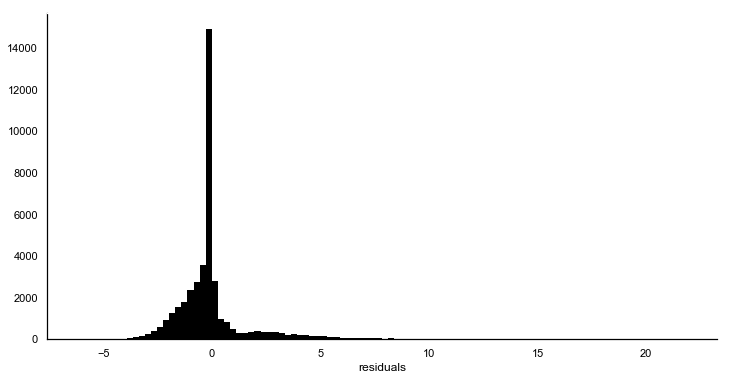

In [753]:
resid(y_train, forest_reg_model.predict(X_train_ss), 'train_res')

In [794]:
def res_v_value(X_train, y_train, pred, filename):
    values=X_train['value'].values
    res=y_train.values-pred
    g=sns.jointplot(x=values, y=np.absolute(res),kind='reg',
                 marginal_kws={'hist_kws':{'alpha':1, 'linewidth':0},'kde':False,
                              'color':axiscolour},
                 joint_kws={'line_kws':{'color':tertiarycolour},
                            'color':axiscolour})
    g.set_axis_labels('value', 'absolute error')
    plt.savefig(f'{filename}.png', facecolor=facecolour)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


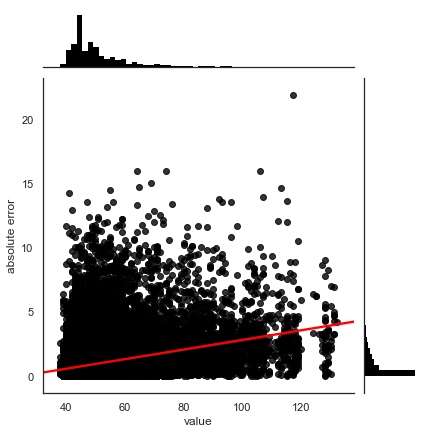

In [795]:
res_v_value(X_train, y_train, forest_reg_model.predict(X_train_ss), 'test')

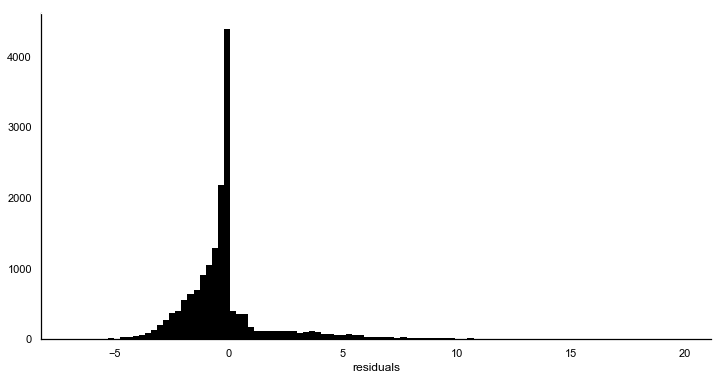

In [131]:
resid(y_test, forest_reg_model.predict(X_test_ss), 'test_res')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (25,102,162,173) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


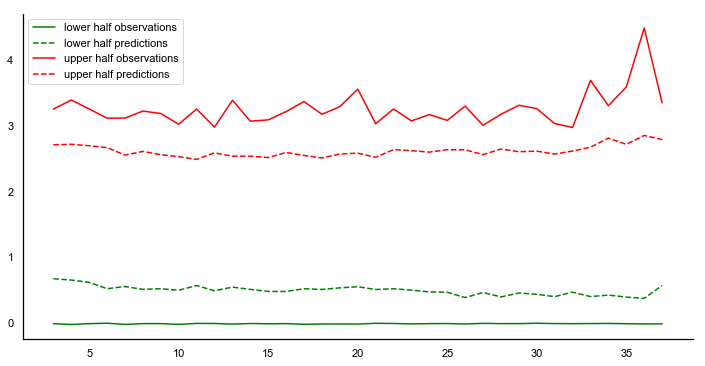

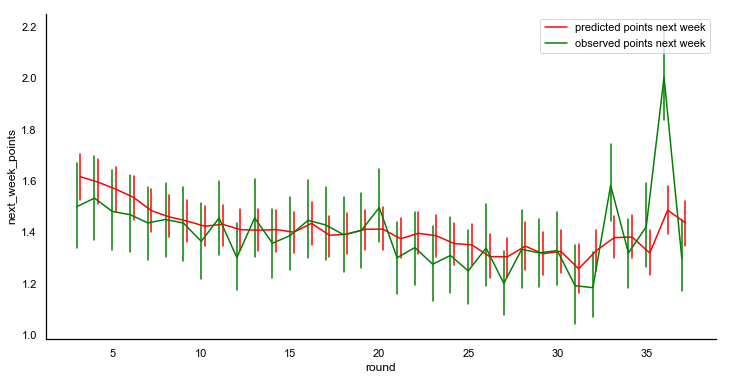

In [724]:
pred_ovr_time('final_dataset.csv', X_train_ss, X_train.index, forest_reg_model, 'forest_weekly', 'forest_weekly_all')

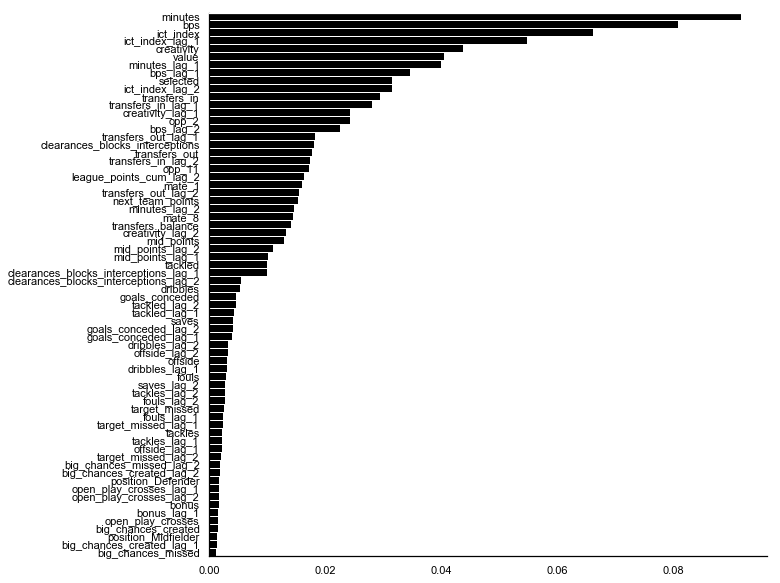

In [723]:
feature_importance(forest_reg_model.feature_importances_, X_train.columns, 'reg_features')

# Classification Analysis

In [257]:
data = pd.read_csv('linear_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Best Model

In [258]:
log_model = load('class_models/log_model')
np.mean(cross_val_score(log_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5231844165205475

In [259]:
rand_log_model = load('class_models/bal_random_log_model')
np.mean(cross_val_score(rand_log_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5231844165205475

In [139]:
smote_log_model = load('class_models/bal_smote_log_model')
np.mean(cross_val_score(smote_log_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.27727223698634795

In [140]:
adasyn_log_model = load('class_models/bal_adasyn_log_model')
np.mean(cross_val_score(adasyn_log_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2716923890011873

In [144]:
data = pd.read_csv('tree_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 69)
X_train (40949, 68)
X_test (16860, 68)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [145]:
tree_class_model = load('class_models/tree_class_model')
np.mean(cross_val_score(tree_class_model, X_train, y_train, cv=4, scoring='precision'))

0.2765151515151515

In [153]:
forest_class_model = load('class_models/forest_class_model')
np.mean(cross_val_score(forest_class_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.15

In [157]:
rand_forest_class_model = load('class_models/bal_random_forest_class_model')
np.mean(cross_val_score(rand_forest_class_model, X_train, y_train, cv=4, scoring='precision'))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125

In [158]:
smote_forest_class_model = load('class_models/bal_smote_forest_class_model')
np.mean(cross_val_score(smote_forest_class_model, X_train, y_train, cv=4, scoring='precision'))

0.37960481449067957

In [267]:
smote_forest_class_model.steps[1]

('randomforestclassifier',
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=30,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [159]:
adasyn_forest_class_model = load('class_models/bal_adasyn_forest_class_model')
np.mean(cross_val_score(adasyn_forest_class_model, X_train, y_train, cv=4, scoring='precision'))

0.36985178054970813

Best model is a Logistic Regression or Random Forest with SMOTE oversampling.

In [521]:
data = pd.read_csv('linear_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [300]:

optimize_thresh(log_model, X_train, y_train, 0.15)


0.74

In [749]:
proba=log_model.predict_proba(X_train)
proba=[x[1] for x in proba]

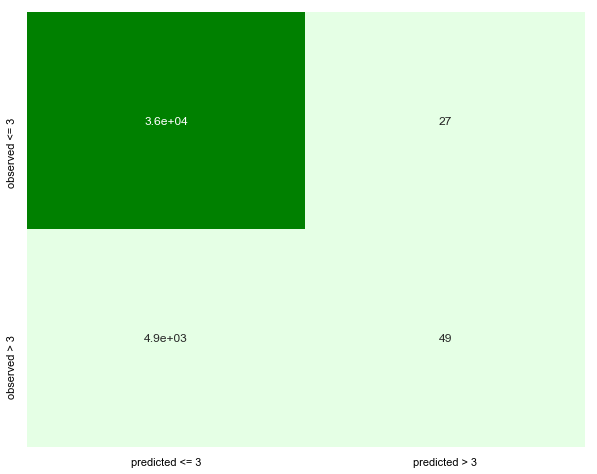

In [302]:
confusion(y_train, proba, thresh=0.74)

In [751]:
report(y_train, proba, thresh=0.5)

Baseline: 0.8803389582163179

threshold: 0.5
              precision    recall  f1-score   support

           0      0.888     0.989     0.936     36049
           1      0.512     0.084     0.144      4900

   micro avg      0.881     0.881     0.881     40949
   macro avg      0.700     0.536     0.540     40949
weighted avg      0.843     0.881     0.841     40949

               predicted <= 3  predicted > 3
observed <= 3           35659            390
observed > 3             4490            410


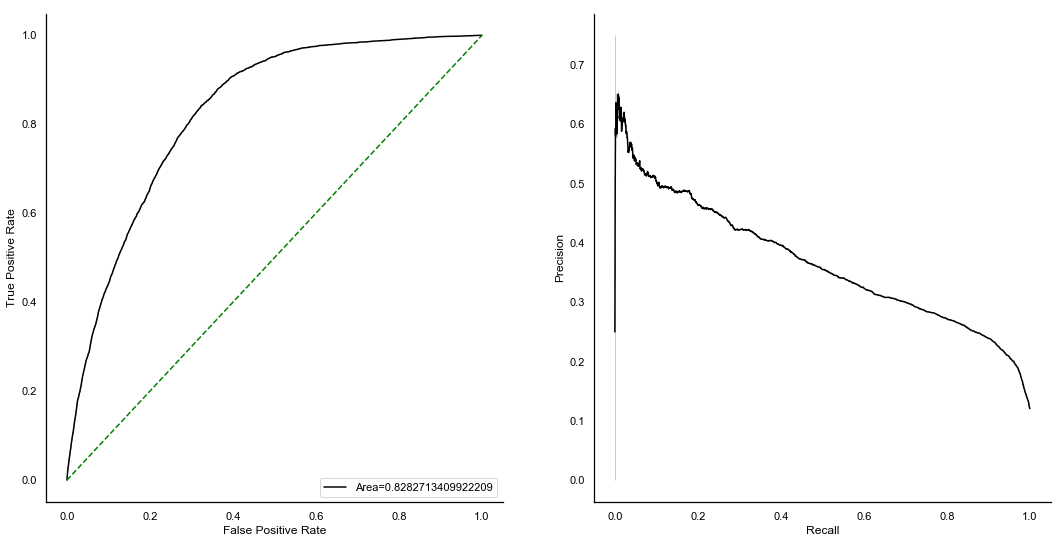

In [745]:
get_roc(y_train, proba)

In [747]:
proba=log_model.predict_proba(X_test)
proba=[x[1] for x in proba]

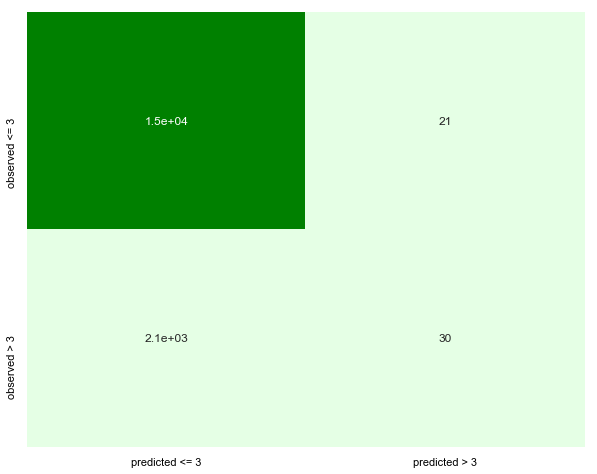

In [306]:
confusion(y_test, proba, thresh=0.74)

In [748]:
report(y_test, proba, thresh=0.74)

Baseline: 0.8750889679715302

threshold: 0.74
              precision    recall  f1-score   support

           0      0.876     0.999     0.934     14754
           1      0.588     0.014     0.028      2106

   micro avg      0.876     0.876     0.876     16860
   macro avg      0.732     0.506     0.481     16860
weighted avg      0.840     0.876     0.820     16860

               predicted <= 3  predicted > 3
observed <= 3           14733             21
observed > 3             2076             30


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


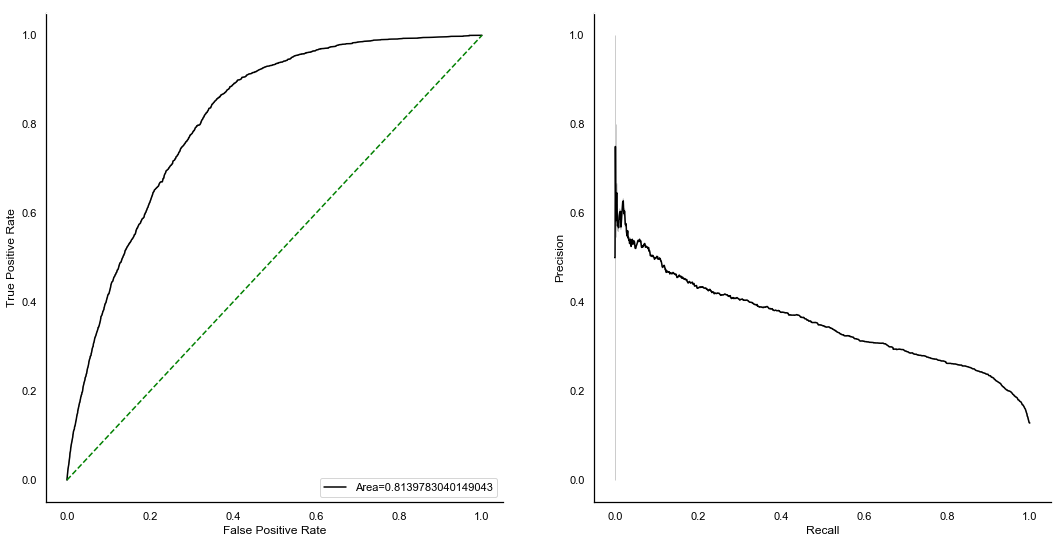

In [308]:
get_roc(y_test, proba)

In [309]:

optimize_thresh(smote_log_model, X_train, y_train, 0.15)


0.9

In [348]:
proba=smote_log_model.predict_proba(X_train)
proba=[x[1] for x in proba]

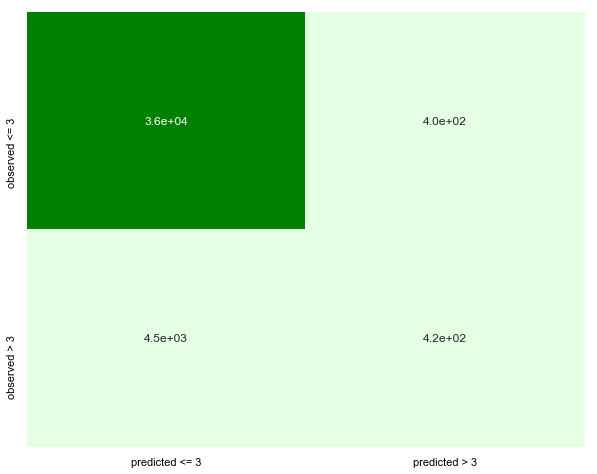

In [311]:
confusion(y_train, proba, thresh=0.9)

In [352]:
report(y_train, proba, thresh=0.9)

Baseline: 0.8803389582163179

threshold: 0.9
              precision    recall  f1-score   support

           0      0.888     0.989     0.936     36049
           1      0.509     0.086     0.147      4900

   micro avg      0.881     0.881     0.881     40949
   macro avg      0.699     0.537     0.541     40949
weighted avg      0.843     0.881     0.841     40949

               predicted <= 3  predicted > 3
observed <= 3           35644            405
observed > 3             4480            420


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


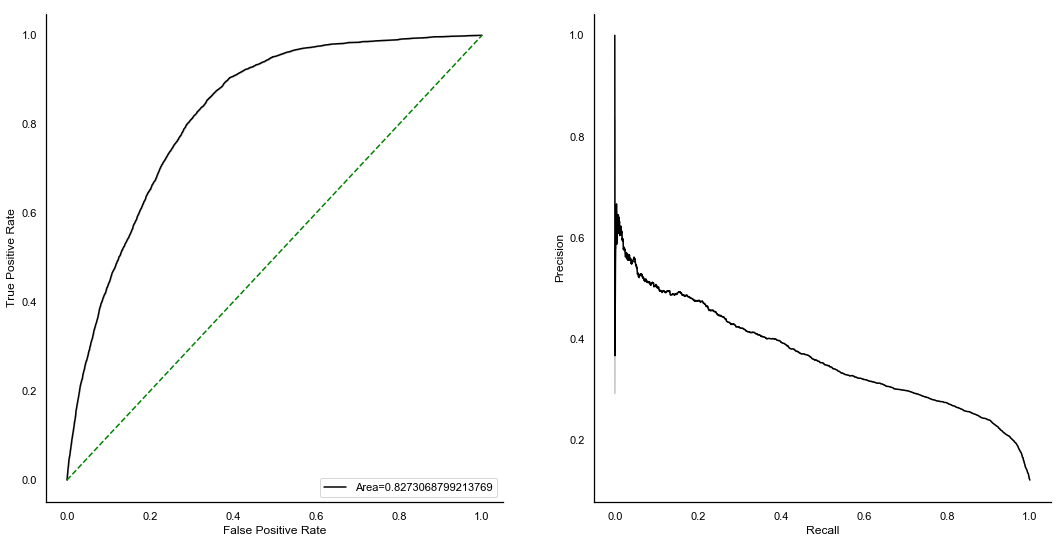

In [313]:
get_roc(y_train, proba)

In [314]:
proba=smote_log_model.predict_proba(X_test)
proba=[x[1] for x in proba]

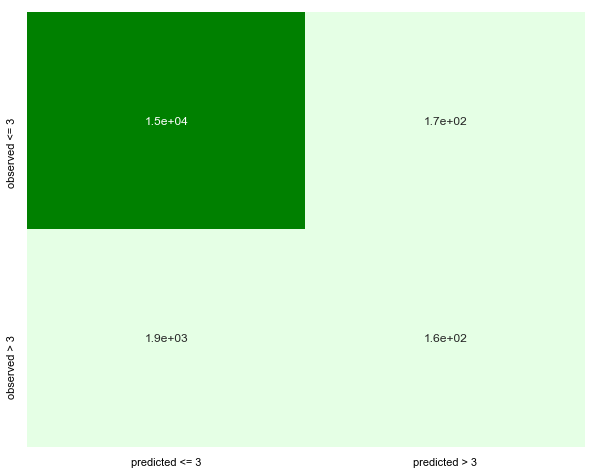

In [315]:
confusion(y_test, proba, thresh=0.9)

In [316]:
report(y_test, proba, thresh=0.9)

Baseline: 0.8750889679715302

threshold: 0.9
              precision    recall  f1-score   support

           0      0.882     0.989     0.932     14754
           1      0.491     0.077     0.134      2106

   micro avg      0.875     0.875     0.875     16860
   macro avg      0.687     0.533     0.533     16860
weighted avg      0.834     0.875     0.833     16860

               predicted <= 3  predicted > 3
observed <= 3           14585            169
observed > 3             1943            163


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


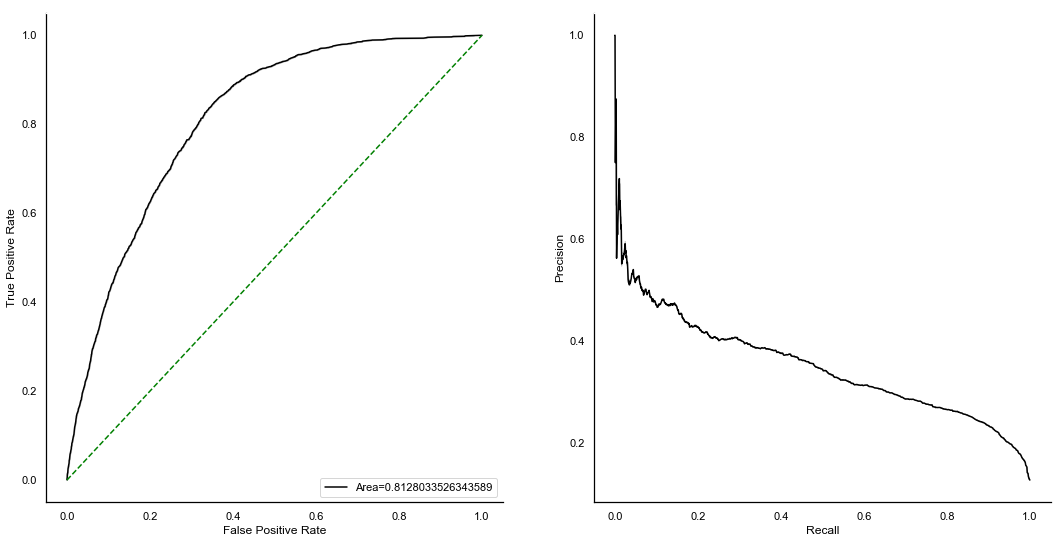

In [317]:
get_roc(y_test, proba)

In [318]:
data = pd.read_csv('tree_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

X (57809, 69)
X_train (40949, 68)
X_test (16860, 68)


In [319]:

optimize_thresh(smote_forest_class_model, X_train, y_train, 0.15)


0.62

In [321]:
proba=smote_forest_class_model.predict_proba(X_train)
proba=[x[1] for x in proba]

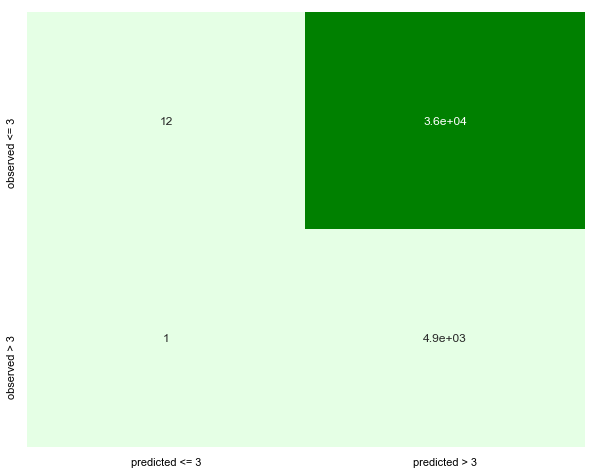

In [327]:
confusion(y_train, proba, thresh=0.62)

In [328]:
report(y_train, proba, thresh=0.62)

Baseline: 0.8803389582163179

threshold: 0.62
              precision    recall  f1-score   support

           0      0.923     0.000     0.001     36049
           1      0.120     1.000     0.214      4900

   micro avg      0.120     0.120     0.120     40949
   macro avg      0.521     0.500     0.107     40949
weighted avg      0.827     0.120     0.026     40949

               predicted <= 3  predicted > 3
observed <= 3              12          36037
observed > 3                1           4899


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


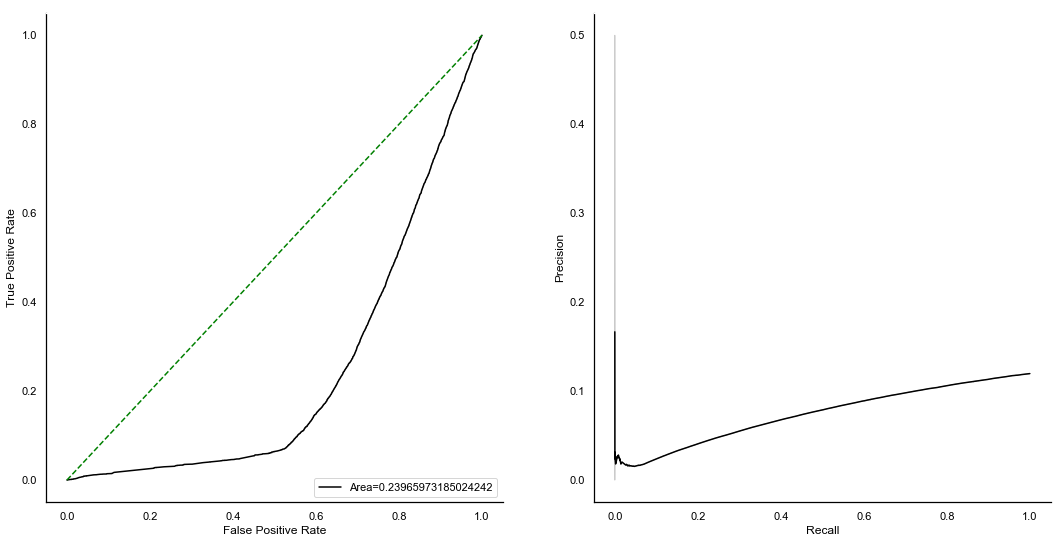

In [329]:
get_roc(y_train, proba)

In [330]:
proba=smote_forest_class_model.predict_proba(X_test)
proba=[x[1] for x in proba]

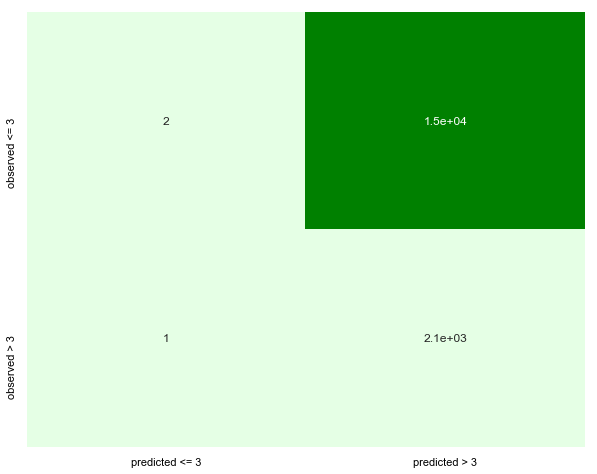

In [331]:
confusion(y_test, proba, thresh=0.62)

In [332]:
report(y_test, proba, thresh=0.62)

Baseline: 0.8750889679715302

threshold: 0.62
              precision    recall  f1-score   support

           0      0.667     0.000     0.000     14754
           1      0.125     1.000     0.222      2106

   micro avg      0.125     0.125     0.125     16860
   macro avg      0.396     0.500     0.111     16860
weighted avg      0.599     0.125     0.028     16860

               predicted <= 3  predicted > 3
observed <= 3               2          14752
observed > 3                1           2105


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


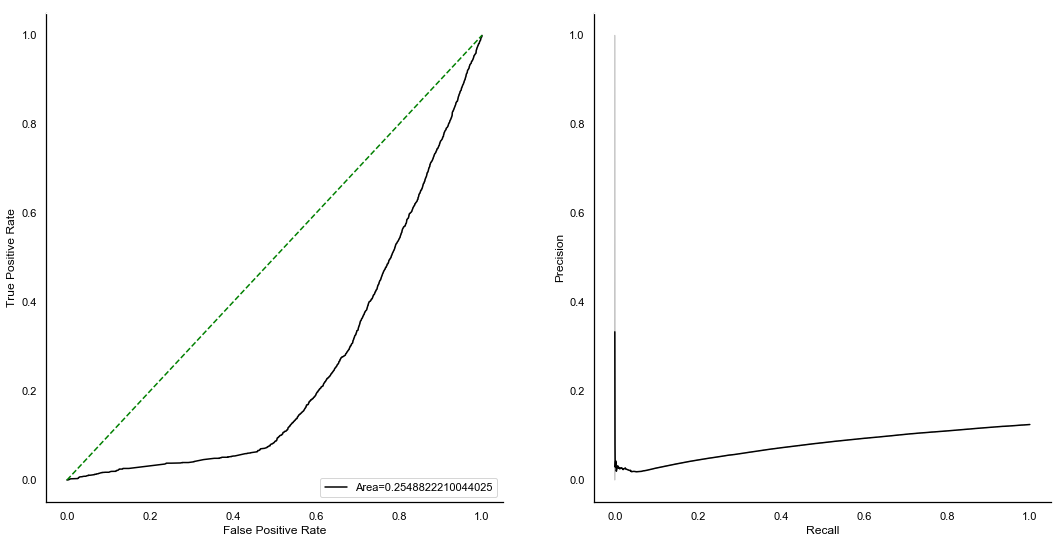

In [333]:
get_roc(y_test, proba)

On first comparison the logistic regression is the best classifier.

In [732]:
data = pd.read_csv('linear_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [733]:
proba1=log_model.predict_proba(X_train)
proba1=[x[1] for x in proba1]

proba2=smote_log_model.predict_proba(X_train)
proba2=[x[1] for x in proba2]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


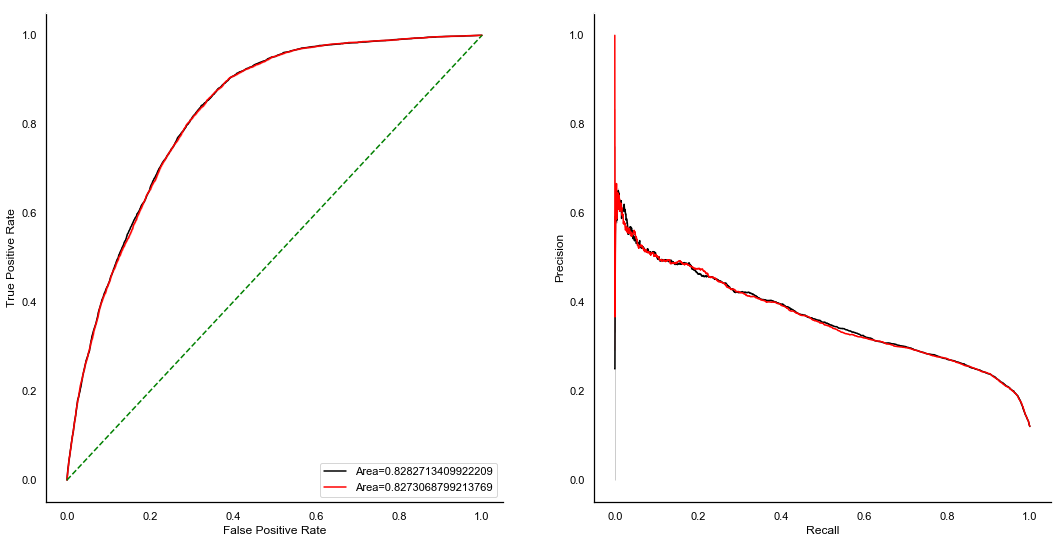

In [734]:
compare_roc(y_train, proba1, proba2)

In [368]:
proba1=log_model.predict_proba(X_test)
proba1=[x[1] for x in proba1]

proba2=smote_log_model.predict_proba(X_test)
proba2=[x[1] for x in proba2]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


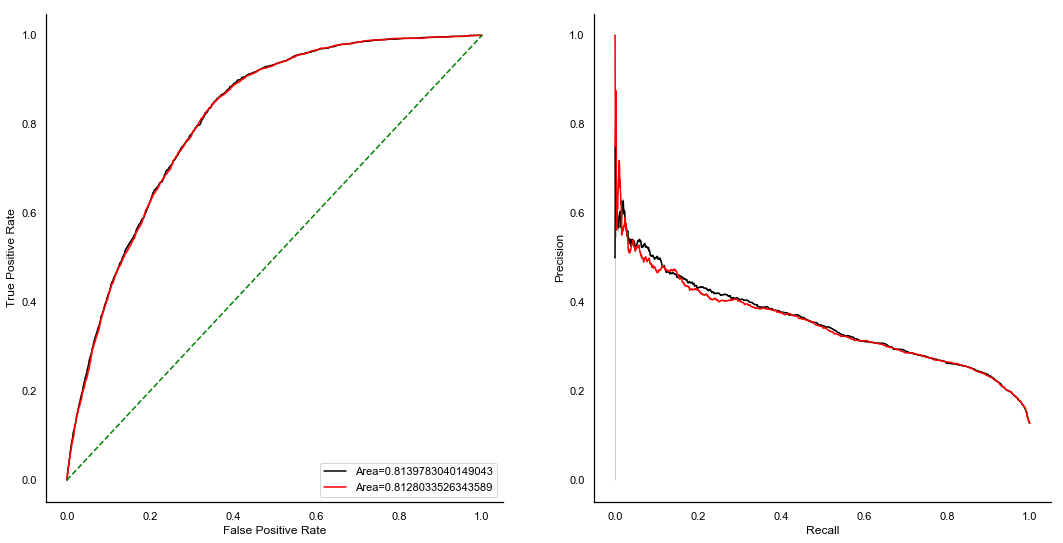

In [369]:
compare_roc(y_test, proba1, proba2)

In [735]:
proba1=log_model.predict_proba(X_train)
proba1=[x[1] for x in proba1]

proba2=smote_log_model.predict_proba(X_train)
proba2=[x[1] for x in proba2]

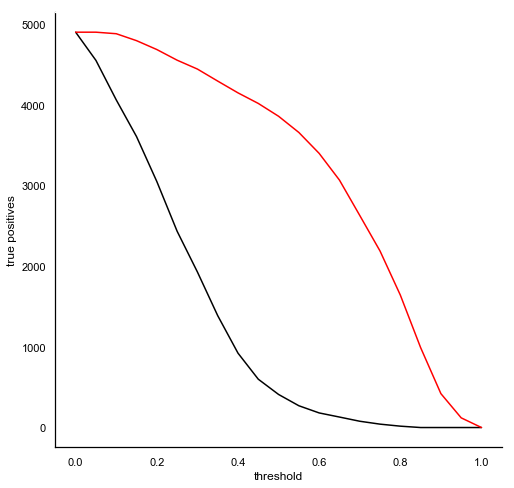

In [736]:
tp_v_thresh(y_train, proba1, proba2, 'tp_v_thresh')

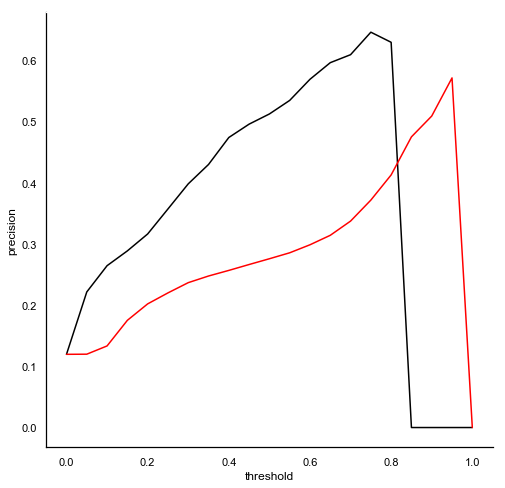

In [738]:
prec_v_thresh(y_train, proba1, proba2, 'prec_v_thresh')

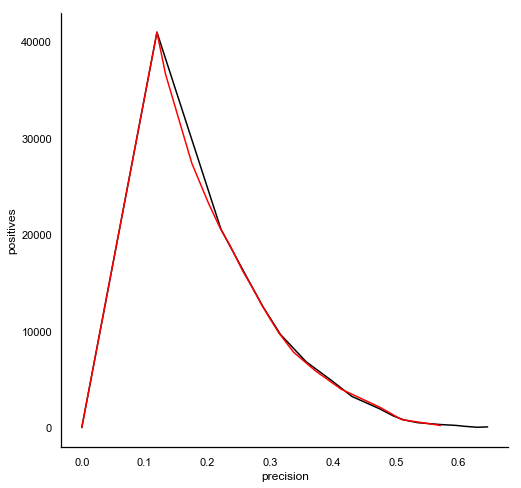

In [741]:
sample_v_prec(y_train, proba1, proba2, 'pos_V_prec')

Comparing the balanced and unbalanced logistic regressions we can see that the balanced classifier produces more positive classifications at any given threshold, however, it also gives a lower precision at any given threshold. Finally, we can see in the last graph that the number of positive predictions against the precision of the classifier (as we adjust threshold). The models are nearly identical expect that the balanced classifier has a lower maximum precision.

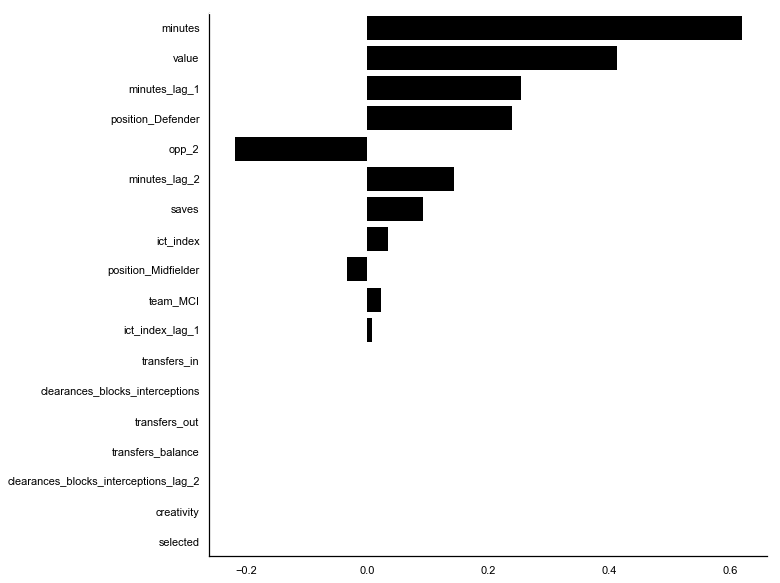

In [434]:
feature_importance(log_model.coef_.flatten(), 
                   coef_names, 'log_features')

In [446]:
log_model

LogisticRegression(C=0.021544346900318846, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

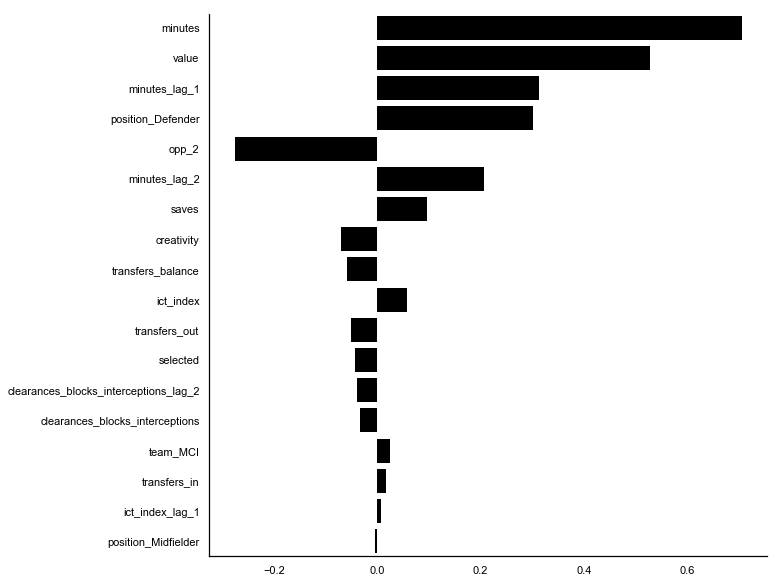

In [443]:
feature_importance(smote_log_model.steps[1][1].coef_.flatten(), 
                   coef_names, 'smote_log_features')


In [445]:
smote_log_model.steps[1][1]

LogisticRegression(C=46.41588833612782, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

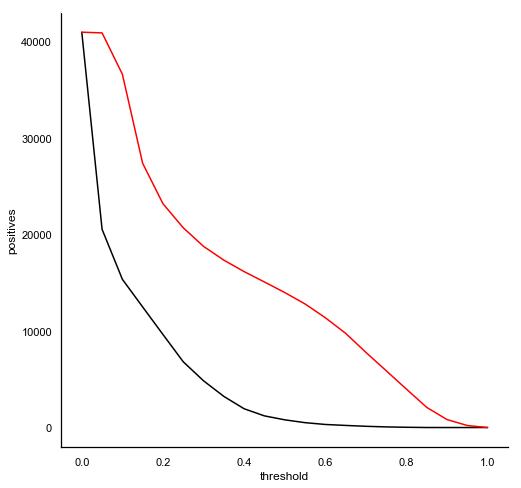

In [743]:
sample_v_thresh(y_train, proba1, proba2, 'pos_V_thresh')

For unbalanced, sample size plateus around 0.4, while the unbalanced doesnt reach this until at least 0.9.
However, while this graph is helpful for understanding threshold progression, remmeber that at any given precision the two models have very similar tp+fp sizes.

In [610]:
data = pd.read_csv('linear_data.csv')

to_drop=['Unnamed: 0']
target='next_week_points'

footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True, classify=True,
                             threshold=3)

X_train, X_test, y_train, y_test, coef_names = footprep.transform(data)

scaler=StandardScaler()
X_train_ss=scaler.fit_transform(X_train)
X_test_ss=scaler.transform(X_test)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [611]:
footprep=FootballPreprocessor(target=target, to_drop=to_drop,
                             time_split=True)

X_train_tmp, X_test_tmp, y_train_actual, y_test_actual, coef_names_tmp = footprep.transform(data)

X (57809, 19)
X_train (40949, 18)
X_test (16860, 18)


In [612]:
#need to adj_round and target
train_index=list(X_train.index)
adj_round=data.loc[train_index, 'adj_round']
X_train['adj_round']=adj_round
X_train['next_week_points']=y_train_actual
X_train['target']=y_train

test_index=list(X_test.index)
adj_round=data.loc[test_index, 'adj_round']
X_test['adj_round']=adj_round
X_test['next_week_points']=y_test_actual
X_test['target']=y_test

In [613]:
tmp=pd.DataFrame(log_model.predict_proba(X_train_ss), index=train_index)
X_train['proba1']=tmp[1]
X_train['pred1']=X_train['proba1'].apply(assign_class, thresh=0.45)

tmp=pd.DataFrame(log_model.predict_proba(X_test_ss), index=test_index)
X_test['proba1']=tmp[1]
X_test['pred1']=X_test['proba1'].apply(assign_class, thresh=0.45)

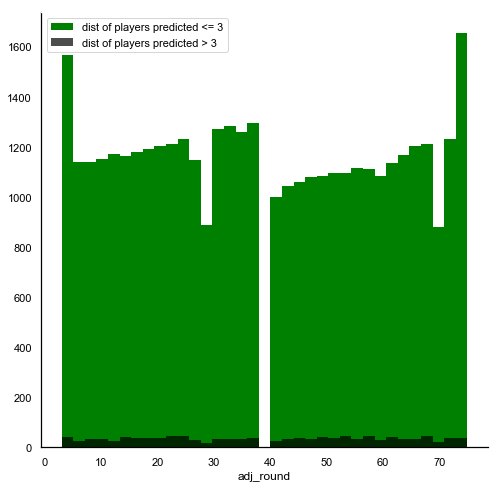

In [614]:
dist_of_week(X_train, 3, 'pred1')

In [615]:
tmp=pd.DataFrame(log_model.predict_proba(X_train_ss), index=train_index)
X_train['proba1']=tmp[1]
X_train['pred1']=X_train['proba1'].apply(assign_class, thresh=0.5)

tmp=pd.DataFrame(log_model.predict_proba(X_test_ss), index=test_index)
X_test['proba1']=tmp[1]
X_test['pred1']=X_test['proba1'].apply(assign_class, thresh=0.5)

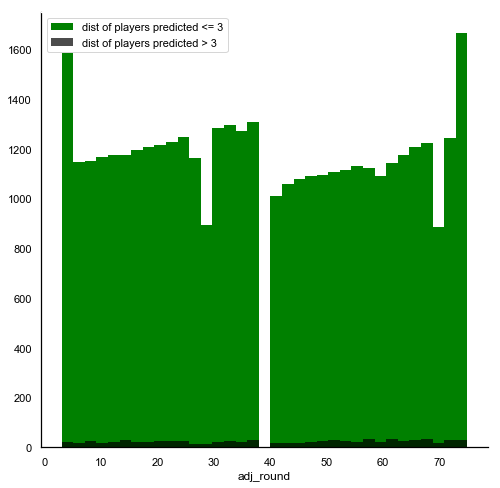

In [616]:
dist_of_week(X_train, 3, 'pred1')

In [617]:
report(y_train, X_train['proba1'], 0.45)

Baseline: 0.8803389582163179

threshold: 0.45
              precision    recall  f1-score   support

           0      0.892     0.983     0.935     36049
           1      0.496     0.122     0.196      4900

   micro avg      0.880     0.880     0.880     40949
   macro avg      0.694     0.553     0.566     40949
weighted avg      0.844     0.880     0.847     40949

               predicted <= 3  predicted > 3
observed <= 3           35440            609
observed > 3             4301            599


In [618]:
report(y_train, X_train['proba1'], 0.5)

Baseline: 0.8803389582163179

threshold: 0.5
              precision    recall  f1-score   support

           0      0.888     0.989     0.936     36049
           1      0.512     0.084     0.144      4900

   micro avg      0.881     0.881     0.881     40949
   macro avg      0.700     0.536     0.540     40949
weighted avg      0.843     0.881     0.841     40949

               predicted <= 3  predicted > 3
observed <= 3           35659            390
observed > 3             4490            410


As you can see from the two histograms and the classification reports there is an issue of positive class size. Therefore the model output needs to be in the form of a range of probabilites for each week for different players.

In [619]:
data_train=data.loc[train_index]

In [620]:
data_train['proba']=X_train['proba1']
data_train['target']=X_train['target']

In [621]:
data_test=data.loc[test_index]
data_test['proba']=X_test['proba1']
data_test['target']=X_test['target']

I can interpret these probabilites two ways, I could assume that all assumptions of logistic regression are met and these are indeed the real probabalities given the features. However, the assumptions are not met so perhaps a more accurate probability would be the precision at a threshold the player passes to be classified as positive. The probability would then be interpretable as the likelihood the positive is true given the probability output of the logistic regression.

In [622]:
from sklearn.metrics import precision_score

In [623]:
def get_prob(df):
    prob_at_thresh=[]
    for thresh in np.linspace(0,1,11):
        df['pred']=df['proba'].apply(assign_class, thresh=thresh)
        prob_at_thresh.append((precision_score(df['target'], df['pred']), thresh))
    return prob_at_thresh

In [628]:
get_prob(data_train)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[(0.11966104178368214, 0.0),
 (0.26452579468473164, 0.1),
 (0.3163519402365636, 0.2),
 (0.3982648213179095, 0.30000000000000004),
 (0.47403598971722366, 0.4),
 (0.5125, 0.5),
 (0.5691823899371069, 0.6000000000000001),
 (0.609375, 0.7000000000000001),
 (0.6296296296296297, 0.8),
 (0.0, 0.9),
 (0.0, 1.0)]

If the player that week has a probability (from the log_model) greater than or equal to one of the thresholds (second element in tuples) then they will be assigned the precision of that threshold level as their likelihood of getting greater than 3 points next week. Do these probabilities hold up in the test set?

In [629]:
get_prob(data_test)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[(0.12491103202846975, 0.0),
 (0.2564883282586632, 0.1),
 (0.30093093743234467, 0.2),
 (0.3706968933669186, 0.30000000000000004),
 (0.4460093896713615, 0.4),
 (0.5227963525835866, 0.5),
 (0.5364238410596026, 0.6000000000000001),
 (0.6111111111111112, 0.7000000000000001),
 (0.5833333333333334, 0.8),
 (0.0, 0.9),
 (0.0, 1.0)]

In [632]:
proba_train=get_prob(data_train)
proba_test=get_prob(data_test)

proba_train_=[x[0] for x in proba_train]
proba_test_=[x[0] for x in proba_test]

diff=[np.abs(x-y) for x,y in zip(proba_train_, proba_test_)]
diff

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.005249990244787603,
 0.008037466426068451,
 0.01542100280421893,
 0.027567927950990945,
 0.02802660004586216,
 0.010296352583586632,
 0.03275854887750429,
 0.0017361111111111605,
 0.04629629629629628,
 0.0,
 0.0]

All precisions are within 0.05 of each other, so the training precisions are good indicators of future precisions. As this is a game with no monetary stakes 0.05 can be viewed as a difference to small to worry about.

As the general trend is an increase in threshold increases the probability of positives being true I am going to drop the last two thresholds 0.9 and 1 where no obsevations were seen and give them the same probability as 0.8.

In [633]:
key = proba_train[:-2]

In [639]:
def assign_real_proba(proba, key):
    for prob, thresh in key:
        if proba>=thresh:
            real_prob=prob
        else:
            break
    return real_prob

In [643]:
data_train['real_proba']=data_train['proba'].apply(assign_real_proba, key=key)

In [686]:
data_test['real_proba']=data_test['proba'].apply(assign_real_proba, key=key)

Now every week I have up to 9 different probabilities that a player will get over 3 points next week, the highest being 0.63 and the lowest being 0.13 (the baseline).

The final aspect of the model that needs analysing is the value of players predicted to be postive. This is important as the model will be more usefull on less valuable players that people know less about. A lot of people will be watching high value players and will likely have a better understanding of when they will do well and when they wont. A good model then will be able to pick low value players just as well as it can predict high value players and so give users insight that they might not otherwise have had.

In [798]:
def value_v_pred(df, thresh, filename):
    df['pred']=0
    df.loc[df['real_proba']>thresh, 'pred']=1
    fig, ax = plt.subplots(figsize=(8,8))
    sns.scatterplot(x='value', y='next_week_points', data=df[df['pred']==0], color=axiscolour, ax=ax,
                   label='predicted 3 or below')
    sns.scatterplot(x='value', y='next_week_points', data=df[df['pred']==1], color=tertiarycolour, ax=ax,
                   label='predicted more than 3')
    
    plt.legend()
    ax=color_axis(ax)
    plt.savefig(f'{filename}.png', facecolor=facecolour)

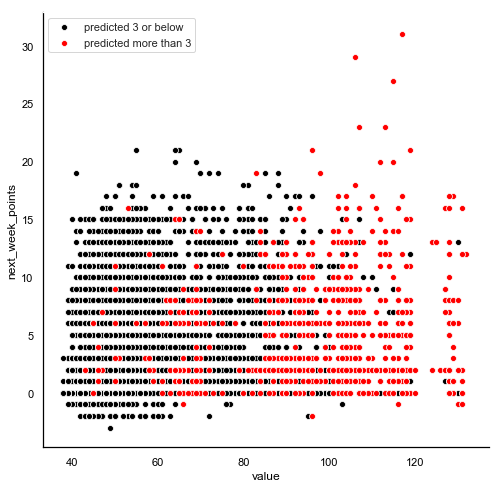

In [801]:
value_v_pred(data_train, 0.5, 'val_V_pred')

There are certainly less players predicted positive as value decreases, but this is to be expected as they are less valuable because they are worse and so are less likely to get above 3 points.

In [807]:
def prec_v_pred(df, thresh, filename):
    df['pred']=0
    df.loc[df['real_proba']>thresh, 'pred']=1
    
    greater_than=np.linspace(40,130,10)
    less_than=np.linspace(50,140,10)
    
    dfs=[]
    avg_val=[]
    for i in range(10):
        a_df=df[(df['value']>=greater_than[i])&(df['value']<less_than[i])]
        dfs.append(a_df)
        avg_val.append(a_df['value'].mean())
    precisions=[]
    for a_df in dfs:
        precisions.append(precision_score(a_df['target'], a_df['pred']))
    
    fig, ax = plt.subplots(figsize=(16,8),nrows=1, ncols=2)
    sns.lineplot(x=avg_val, y=precisions, color=axiscolour, ax=ax[0])
    sns.distplot(df[df['pred']==1]['value'], kde=False, hist_kws={'alpha':1,'linewidth':0}, 
                 color=axiscolour, ax=ax[1])
    
    
    ax[0]=color_axis(ax[0])
    ax[1]=color_axis(ax[1])
    
    ax[0].set_xlabel('value')
    ax[0].set_ylabel('precision')
    plt.savefig(f'{filename}.png', facecolor=facecolour)

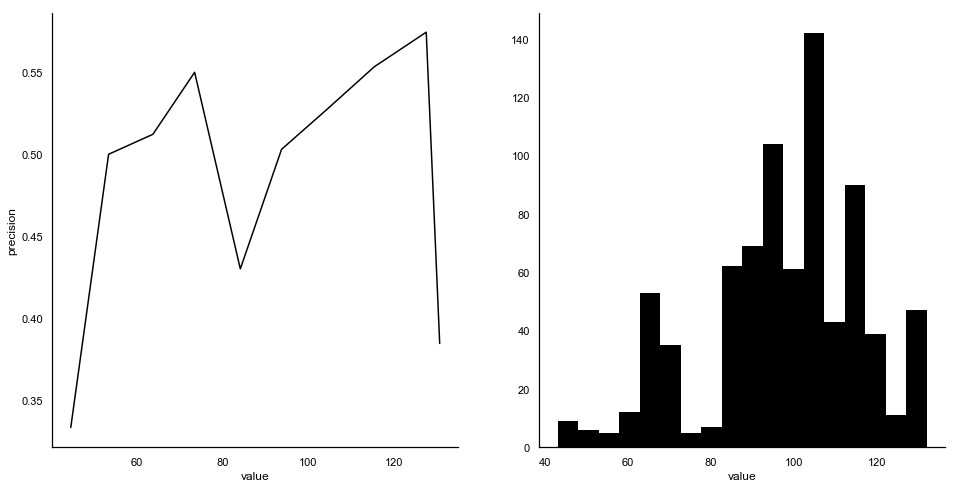

In [811]:
prec_v_pred(data_train, 0.5, 'prec_v_value_50')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarnin

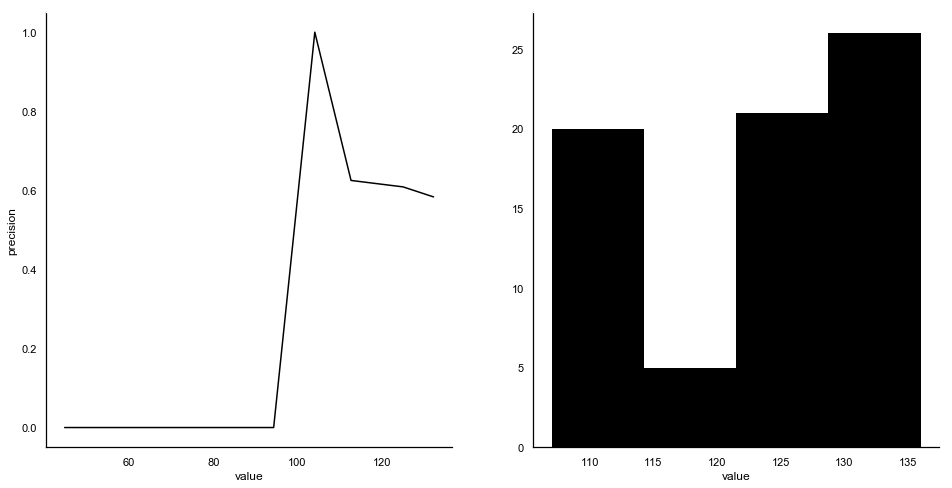

In [813]:
prec_v_pred(data_test, 0.6, 'pred_v_value_test60')

The model is not so great at low value players, it struggles to get high precision when below £60. Its worse in the test set.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarnin

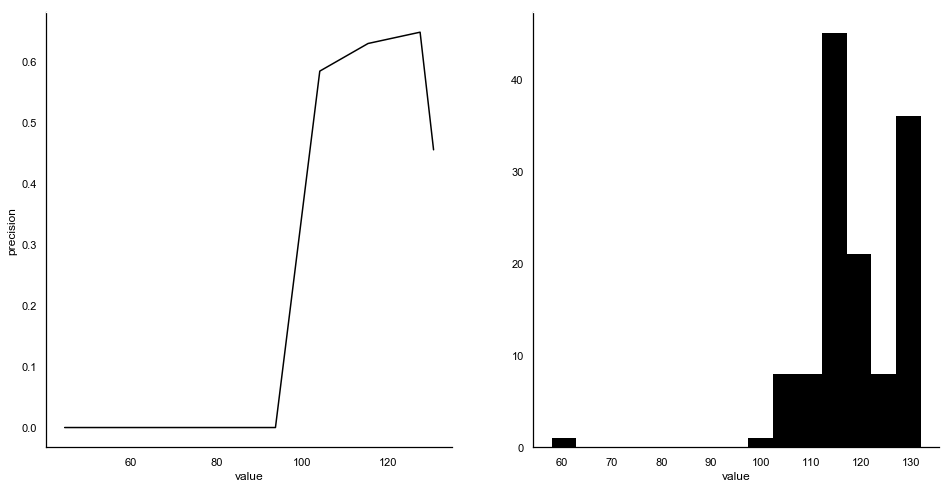

In [810]:
prec_v_pred(data_train, 0.6, 'perv_v_value_60')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


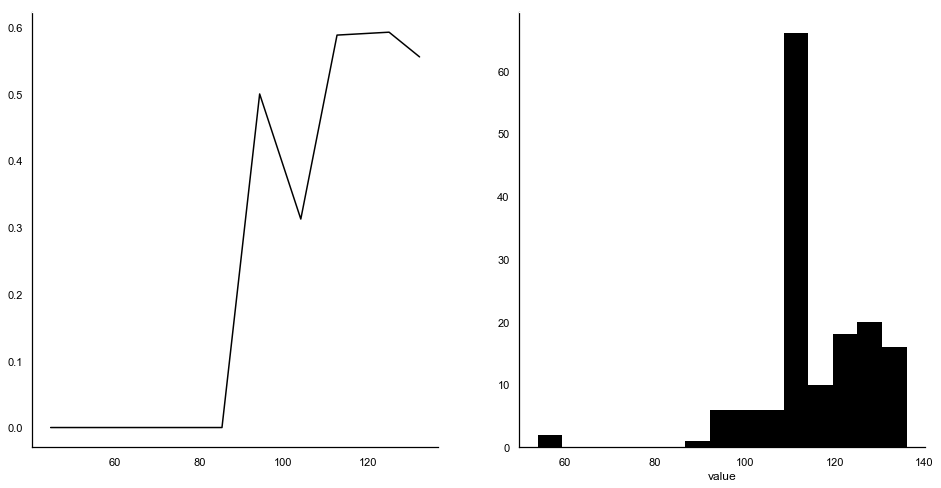

In [719]:
prec_v_pred(data_test, 0.55)

Futher it gets worse for higher likelihood players, where above 0.55 no players below £90 have true positive predictions and so precision is zero.